In [1]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import emoji
from pythainlp.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preprocessing

In [2]:
# Preprocessing functions from model.ipynb
def clean_text(text):
    if pd.isna(text):
        return text
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Normalize emojis (convert to text description)
    text = emoji.demojize(text, language='en')
    
    return text.strip()

def lowercase_english(text):
    if pd.isna(text):
        return text
    
    result = []
    for char in str(text):
        # Check if character is English
        if ord(char) < 128:
            result.append(char.lower())
        else:
            result.append(char)
    
    return ''.join(result)

def calculate_thai_length(text):
    if pd.isna(text):
        return 0
    
    # Tokenize using PyThaiNLP
    tokens = word_tokenize(str(text), engine='newmm')
    return len(tokens)

def prepare_dataset(dataset_file):
    print(f"Processing {dataset_file}...")
    
    df = pd.read_csv(dataset_file)
    print(f"  Original shape: {df.shape}")
    
    # Handle missing labels (drop rows with missing category or texts)
    df = df.dropna(subset=['category', 'texts'])
    print(f"  After dropping missing labels: {df.shape}")
    
    # Clean text (remove URLs, normalize emojis)
    df['texts'] = df['texts'].apply(clean_text)
    
    # Lowercase English characters (keep Thai)
    df['texts'] = df['texts'].apply(lowercase_english)
    
    # Drop rows with empty texts after cleaning
    df = df[df['texts'].str.strip() != '']
    print(f"  After removing empty texts: {df.shape}")
    
    # Map labels - pos -> neu
    df['category'] = df['category'].replace({'pos': 'neu'})
    
    # map to binary: neg vs non-neg
    df['category'] = df['category'].map({'neg': 1, 'neu': 0})
    
    # Recalculate length using PyThaiNLP word tokenization
    df['length'] = df['texts'].apply(calculate_thai_length)
    
    # Add dataset source
    df['source'] = dataset_file.split('/')[-1]
    
    print(f"  Final shape: {df.shape}")
    print(f"  Label distribution: {df['category'].value_counts().to_dict()}")
    print()
    
    return df

In [3]:
# Load and combine datasets (same as model.ipynb)
df1 = prepare_dataset('datasets/dataset1.csv')
df2 = prepare_dataset('datasets/dataset2.csv')
df3 = prepare_dataset('datasets/dataset3.csv')

# Combine all datasets
all_dfs = [df1, df2, df3]
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined shape before deduplication: {combined_df.shape}")

# Remove duplicated samples
combined_df = combined_df.drop_duplicates(subset=['texts'], keep='first')
print(f"Combined shape after deduplication: {combined_df.shape}")

# Display final statistics
print(f"Total samples: {len(combined_df)}")
print(f"\nLabel distribution:")
print(combined_df['category'].value_counts())
print(f"\nLength statistics:")
print(combined_df['length'].describe())

Processing datasets/dataset1.csv...
  Original shape: (23545, 3)
  After dropping missing labels: (23545, 3)
  After removing empty texts: (23542, 3)
  Final shape: (23542, 4)
  Label distribution: {0: 17402, 1: 6140}

Processing datasets/dataset2.csv...
  Original shape: (2160, 3)
  After dropping missing labels: (2160, 3)
  After removing empty texts: (2160, 3)
  Final shape: (2160, 4)
  Label distribution: {1: 1332, 0: 828}

Processing datasets/dataset3.csv...
  Original shape: (4953, 3)
  After dropping missing labels: (4953, 3)
  After removing empty texts: (4953, 3)
  Final shape: (4953, 4)
  Label distribution: {0: 4428, 1: 525}

Combined shape before deduplication: (30655, 4)
Combined shape after deduplication: (30620, 4)
Total samples: 30620

Label distribution:
category
0    22634
1     7986
Name: count, dtype: int64

Length statistics:
count    30620.000000
mean        42.733867
std        124.197009
min          1.000000
25%          7.000000
50%         16.000000
75%      

In [4]:
display(combined_df.shape)
display(combined_df.head())

(30620, 4)

,category,texts,length,source
0,1,อิเหี้ยออมทำกูอยากกินเอ็มเค,9,dataset1.csv
1,1,เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ต...,127,dataset1.csv
2,1,เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ,11,dataset1.csv
3,1,ลิปมันของเเบร์น mistine ราคากลาง ๆ ไม่แพงมาก ร...,23,dataset1.csv
4,1,ทำไมมันไม่มีโปรให้เร๊าาาาาา,7,dataset1.csv


In [5]:
# Train/test split
X = combined_df['texts'].values
y = combined_df['category'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test distribution: {pd.Series(y_test).value_counts().to_dict()}")

Train samples: 24496
Test samples: 6124
Train distribution: {0: 18107, 1: 6389}
Test distribution: {0: 4527, 1: 1597}


## 2. Model Setup and Training Configuration

In [6]:
# Training configuration
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    MAX_LENGTH = 128
    BATCH_SIZE = 16
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    MAX_LENGTH = 96
    BATCH_SIZE =16
else:
    device = torch.device("cpu")
    MAX_LENGTH = 64
    BATCH_SIZE = 8
    
print(f"Device: {device}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Device: mps
Max length: 96
Batch size: 16
Epochs: 3
Learning rate: 2e-05


In [7]:
# Define 3 BERT models to compare
MODELS = {
    'WangchanBERTa': 'airesearch/wangchanberta-base-att-spm-uncased',
    'XLM-RoBERTa': 'xlm-roberta-base',
    'PhayaThaiBERT': 'clicknext/phayathaibert'
}

for name, model_id in MODELS.items():
    print(f"  - {name}: {model_id}")

  - WangchanBERTa: airesearch/wangchanberta-base-att-spm-uncased
  - XLM-RoBERTa: xlm-roberta-base
  - PhayaThaiBERT: clicknext/phayathaibert


In [8]:
# Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

In [10]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels, total_loss / len(dataloader)

## 3. Train and Evaluate All Models

In [11]:
# Main comparison loop
results = []

for model_name, model_id in MODELS.items():
    print(f"\n{'='*80}")
    print(f"Training {model_name} ({model_id})")
    print(f"{'='*80}\n")
    
    if 'wangchanberta' in model_id.lower():
        from transformers import CamembertTokenizer
        tokenizer = CamembertTokenizer.from_pretrained(model_id)
    else:
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            trust_remote_code=True
        )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=2,
        trust_remote_code=True
    )
    model.to(device)
    
    # Create dataloaders
    train_dataset = ToxicityDataset(X_train, y_train, tokenizer, MAX_LENGTH)
    test_dataset = ToxicityDataset(X_test, y_test, tokenizer, MAX_LENGTH)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
)
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 60)
        
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f"Training Loss: {train_loss:.4f}")
        
        predictions, true_labels, val_loss = evaluate(model, test_loader, device)
        
        f1 = f1_score(true_labels, predictions, average='macro')
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Macro F1: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            # Save best predictions
            best_predictions = predictions
            best_true_labels = true_labels
    
    # Calculate final metrics
    accuracy = accuracy_score(best_true_labels, best_predictions)
    precision = precision_score(best_true_labels, best_predictions, average='weighted', pos_label=1)
    recall = recall_score(best_true_labels, best_predictions, average='weighted', pos_label=1)
    f1 = f1_score(best_true_labels, best_predictions, average='weighted', pos_label=1)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"\n{model_name} Final Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Clear memory
    del model, tokenizer, train_dataset, test_dataset, train_loader, test_loader
    torch.cuda.empty_cache() if torch.cuda.is_available() else None


Training WangchanBERTa (airesearch/wangchanberta-base-att-spm-uncased)



Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [23:37<00:00,  1.08it/s, loss=0.204] 


Training Loss: 0.3966


Evaluating: 100%|██████████| 383/383 [02:04<00:00,  3.09it/s]


Validation Loss: 0.2941
Macro F1: 0.8372

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [34:00<00:00,  1.33s/it, loss=0.112] 


Training Loss: 0.2783


Evaluating: 100%|██████████| 383/383 [02:59<00:00,  2.14it/s]


Validation Loss: 0.2865
Macro F1: 0.8464

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [40:47<00:00,  1.60s/it, loss=0.369]  


Training Loss: 0.2138


Evaluating: 100%|██████████| 383/383 [02:04<00:00,  3.07it/s]


Validation Loss: 0.3052
Macro F1: 0.8569

WangchanBERTa Final Results:
  Accuracy:  0.8914
  Precision: 0.8900
  Recall:    0.8914
  F1-Score:  0.8905

Training XLM-RoBERTa (xlm-roberta-base)



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [47:18<00:00,  1.85s/it, loss=0.581] 


Training Loss: 0.4279


Evaluating: 100%|██████████| 383/383 [01:59<00:00,  3.21it/s]


Validation Loss: 0.3451
Macro F1: 0.8103

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [44:02<00:00,  1.73s/it, loss=0.565] 


Training Loss: 0.3185


Evaluating: 100%|██████████| 383/383 [01:52<00:00,  3.41it/s]


Validation Loss: 0.3536
Macro F1: 0.8325

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [43:57<00:00,  1.72s/it, loss=0.224] 


Training Loss: 0.2551


Evaluating: 100%|██████████| 383/383 [01:39<00:00,  3.86it/s]


Validation Loss: 0.3255
Macro F1: 0.8402

XLM-RoBERTa Final Results:
  Accuracy:  0.8775
  Precision: 0.8768
  Recall:    0.8775
  F1-Score:  0.8772

Training PhayaThaiBERT (clicknext/phayathaibert)



Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [38:18<00:00,  1.50s/it, loss=0.0605]


Training Loss: 0.3229


Evaluating: 100%|██████████| 383/383 [01:47<00:00,  3.55it/s]


Validation Loss: 0.2749
Macro F1: 0.8457

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [38:07<00:00,  1.49s/it, loss=0.0484] 


Training Loss: 0.2099


Evaluating: 100%|██████████| 383/383 [01:37<00:00,  3.92it/s]


Validation Loss: 0.3043
Macro F1: 0.8584

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 1531/1531 [38:13<00:00,  1.50s/it, loss=0.102]  


Training Loss: 0.1401


Evaluating: 100%|██████████| 383/383 [01:40<00:00,  3.81it/s]


Validation Loss: 0.3861
Macro F1: 0.8512

PhayaThaiBERT Final Results:
  Accuracy:  0.8904
  Precision: 0.8909
  Recall:    0.8904
  F1-Score:  0.8906


## 4. Results Comparison

In [12]:
all_results = results
results_df = pd.DataFrame(all_results)

print(results_df.to_string(index=False))

# Find best models
best_acc_idx = results_df['Accuracy'].idxmax()
best_f1_idx = results_df['F1-Score'].idxmax()

print(f"Best Model by Accuracy: {results_df.loc[best_acc_idx, 'Model']} ({results_df.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"Best Model by F1-Score: {results_df.loc[best_f1_idx, 'Model']} ({results_df.loc[best_f1_idx, 'F1-Score']:.4f})")

        Model  Accuracy  Precision   Recall  F1-Score
WangchanBERTa  0.891411   0.889992 0.891411  0.890527
  XLM-RoBERTa  0.877531   0.876825 0.877531  0.877153
PhayaThaiBERT  0.890431   0.890869 0.890431  0.890640
Best Model by Accuracy: WangchanBERTa (0.8914)
Best Model by F1-Score: PhayaThaiBERT (0.8906)


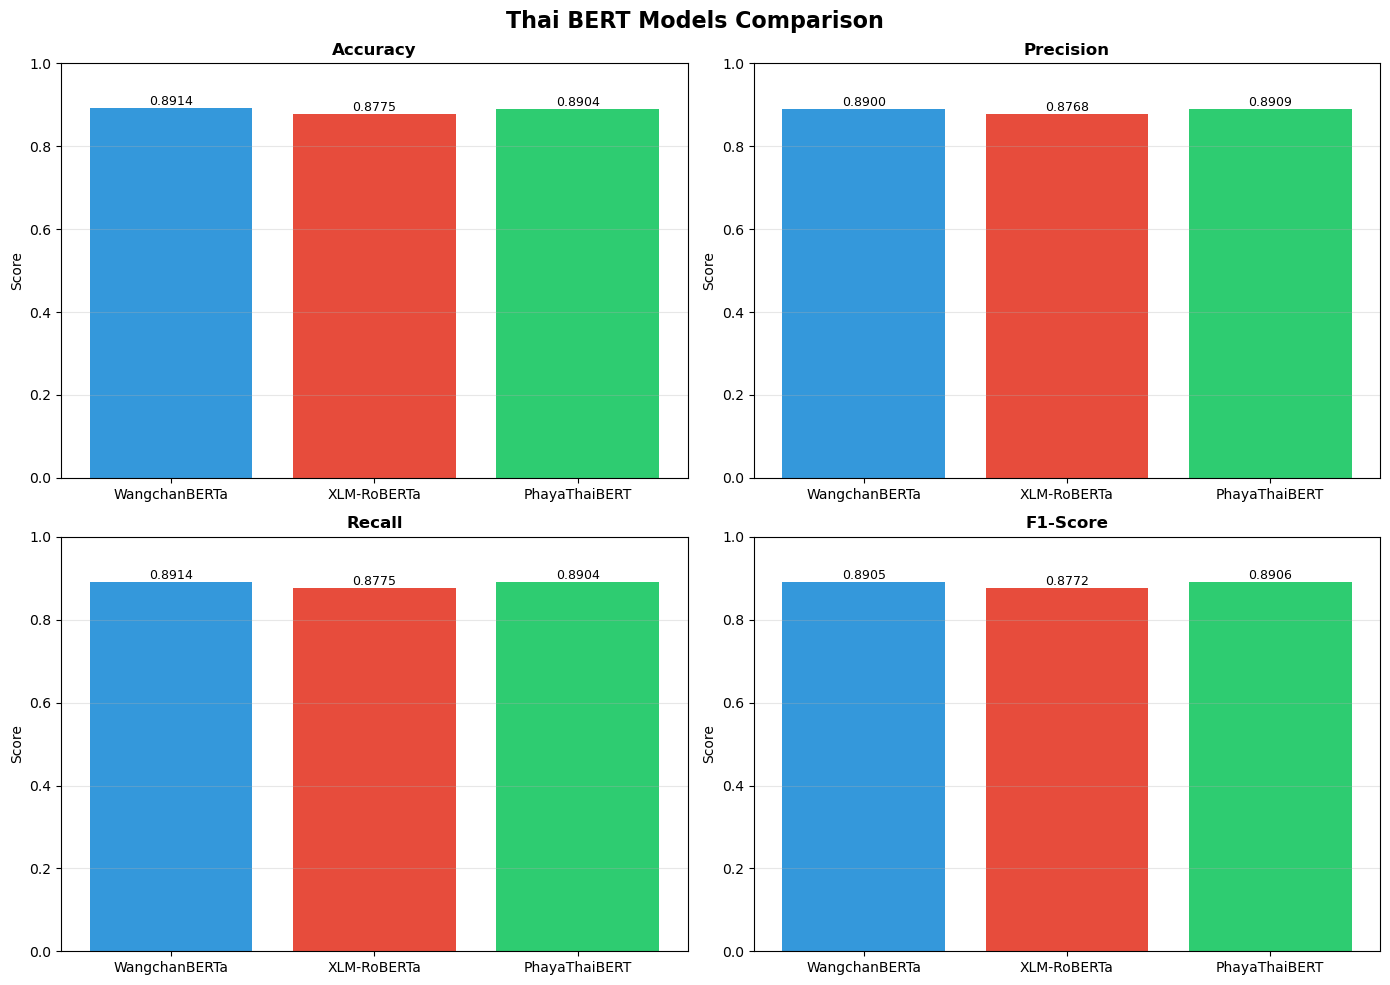

In [13]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Thai BERT Models Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('thai_bert_comparison.png', dpi=150, bbox_inches='tight')
plt.show()